In [1]:
import pandas as pd
import json
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 150

In [3]:
data = pd.read_csv("../data/finaldata.csv")

In [4]:
metadata = pd.read_csv("../data/metadata.csv")

In [5]:
journal_metadata = pd.read_csv("../data/journal_metadata.csv")
journal_subjects_lookup = {row[1].title: row[1].subjects for row in journal_metadata.iterrows()}
metadata["journal_subjects"] = metadata.journal.map(lambda x: journal_subjects_lookup.get(x, ""))
metadata.loc[metadata.paper_type != "journal-article", "journal_subjects"] = "preprint"

In [6]:
with open("../rawdata/references_metadata_raw.json", "r") as f:
    references_raw = json.load(f)

In [7]:
dois = list(metadata.doi)

In [8]:
references = {k: [x["doi"] for x in v if x["doi"]] for (k,v) in references_raw.items()}

In [9]:
references_internal = {k: [d for d in v if d in dois] for (k,v) in references.items()}

In [10]:
graph = nx.DiGraph()
graph.add_nodes_from(dois)
for (v1, vs) in references_internal.items():
    for v2 in vs:
        graph.add_edge(v1, v2)

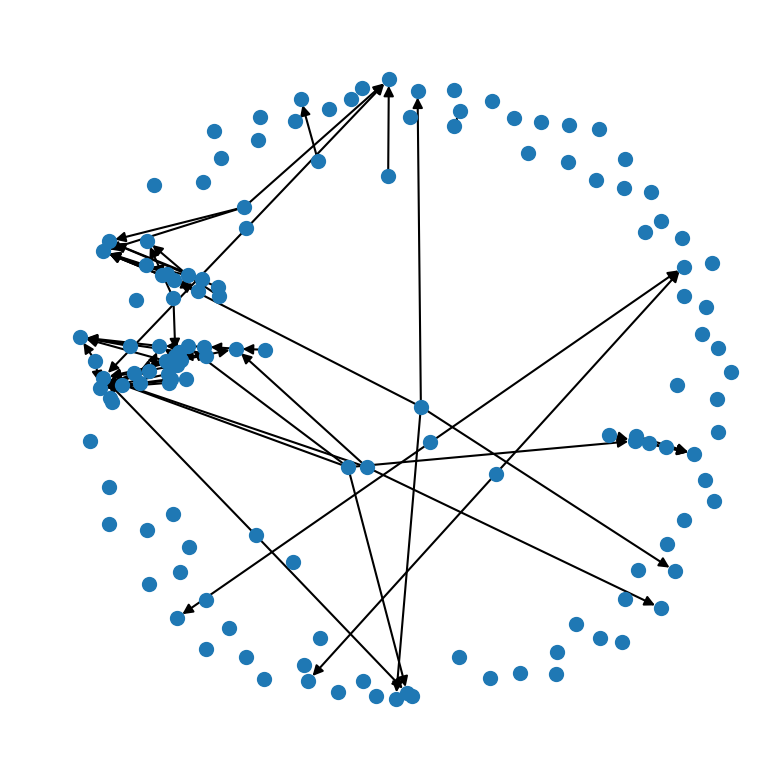

In [11]:
nx.draw(graph, node_size=40)

In [12]:
references_internal_connected = {k:v for (k,v) in references_internal.items() if v}
graph_connected = nx.DiGraph()
for (v1, vs) in references_internal_connected.items():
    for v2 in vs:
        graph_connected.add_edge(v1, v2)

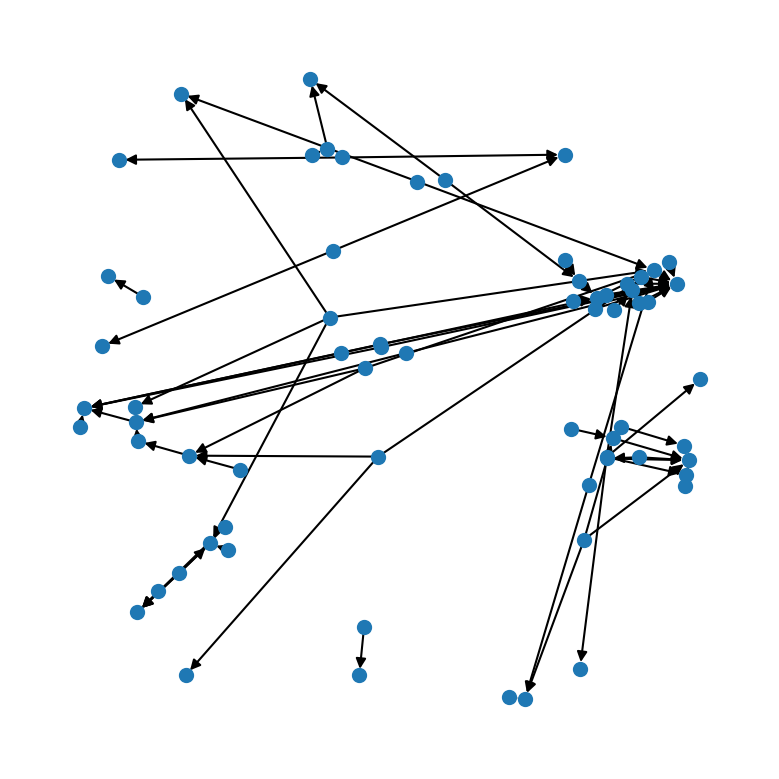

In [13]:
nx.draw(graph_connected, node_size=40)

In [14]:
G = graph_connected

In [15]:
communities = nx.community.girvan_newman(G)

In [16]:
communities = list(communities)
selected_communities = communities[0]

In [17]:
node_groups = []
for com in selected_communities:
    node_groups.append(list(com))
    
assignments = []
for node in G:
    for i, group in enumerate(node_groups):
        if node in group:
            assignments.append(i)
            break

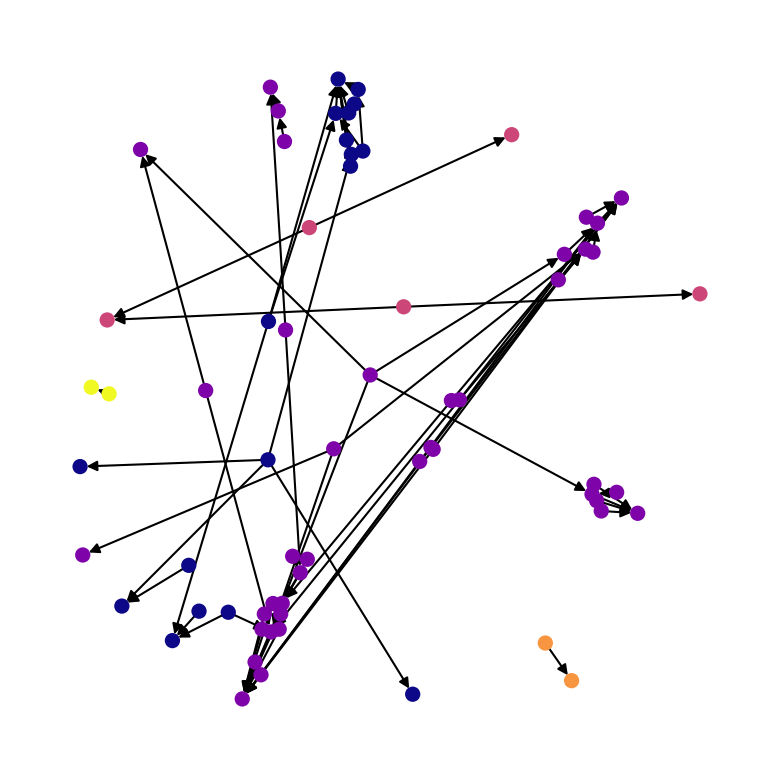

In [18]:
np.random.seed(0)
nx.draw(G, node_color=assignments, cmap=plt.cm.plasma, with_labels=False, node_size=40)
plt.savefig("../figures/citation-network/network-clustered-v1.png", dpi=300);
plt.show()

In [19]:
combineddata = pd.merge(metadata, data, on="doi", how="outer")

In [20]:
clustered_combineddata = {f"cluster_{i+1}": combineddata[combineddata.doi.isin(s)] for i, s in enumerate(selected_communities)}
clustered_combineddata["isolated"] = combineddata[~combineddata.doi.isin(list(G.nodes))]

In [21]:
with pd.ExcelWriter("../results/clusters-v1.xlsx") as writer:
    for sheet_name, df in clustered_combineddata.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)